# 11. *Data Augmentation* y *Transfer Learning*
[**Python Deep Learning** Introducción práctica con Keras y TensorFlow 2. Jordi Torres. Editorial Marcombo ISBN: 9788426728289 ](https://www.marcombo.com/python-deep-learning-9788426728289/)


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 63kB/s 
     |████████████████████████████████| 3.0MB 26.7MB/s 
     |████████████████████████████████| 419kB 36.5MB/s 



Carga de los datos


In [0]:
!wget --no-check-certificate \
  https://www.dropbox.com/s/sshnskxxolkrq9h/cats_and_dogs_small.zip?dl=0 \
  -O /tmp/cats_and_dogs_small.zip



--2019-09-03 09:32:36--  https://www.dropbox.com/s/sshnskxxolkrq9h/cats_and_dogs_small.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/sshnskxxolkrq9h/cats_and_dogs_small.zip [following]
--2019-09-03 09:32:37--  https://www.dropbox.com/s/raw/sshnskxxolkrq9h/cats_and_dogs_small.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7fb7cf40d9d30b76e22a09a3f3.dl.dropboxusercontent.com/cd/0/inline/An2N0GrDCtW2vKGvCXTIQjfOapqRkjSelxlmm3k1jQLDFF_VAD2N34Il0DjXVU_4q2VfwyJR3VV9CavvcdFnIVqyBJ8fh65nqO7c2_AFluK6dZIWcgfO0MWw5n_mRvWzK0Y/file# [following]
--2019-09-03 09:32:37--  https://uc7fb7cf40d9d30b76e22a09a3f3.dl.dropboxusercontent.com/cd/0/inline/An2N0GrDCtW2vKGvCXTIQjfOapqRkjSelxlmm3k1jQLDFF_VAD2N34Il0DjXVU_4q2VfwyJR3VV9

In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_small.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()


In [0]:

base_dir = '/tmp/cats_and_dogs_small'

train_dir =      os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir =       os.path.join(base_dir, 'test')

# Directorio con las imagenes de training 
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directorio con las imagenes de validation
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directorio con las imagenes de test
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')



In [0]:
print('total training cat images :', len(os.listdir(train_cats_dir ) ))
print('total training dog images :', len(os.listdir(train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

print('total test cat images :', len(os.listdir( test_cats_dir ) ))
print('total test dog images :', len(os.listdir( test_dogs_dir ) ))


total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500
total test cat images : 500
total test dog images : 500


Saving Wiliams-foto1.jpg to Wiliams-foto1.jpg


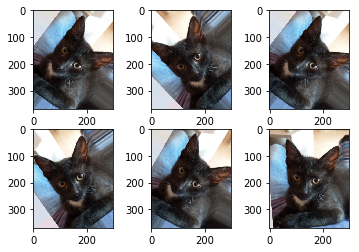

In [0]:
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

from google.colab import files
from tensorflow.keras.preprocessing import image
 
uploaded=files.upload()
for fn in uploaded.keys():
  path='/content/' + fn
  img=image.load_img(path)
  data = img_to_array(img)
  samples = expand_dims(data, 0)
  
  # example of "rotation_range"
  datagen = ImageDataGenerator(rotation_range=45)

  it = datagen.flow(samples, batch_size=1)
  for i in range(6):
  	pyplot.subplot(230 + 1 + i)
  	batch = it.next()
  	image = batch[0].astype('uint8')
  	pyplot.imshow(image)
pyplot.show()

### ModelDA: Modelo con *Data Augmentation*

In [0]:
import tensorflow as tf

modelDA = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop

modelDA.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])



In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


test_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
batch_size = 20
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

historyDA = modelDA.fit_generator(
      train_generator,
      steps_per_epoch= steps_per_epoch,
      epochs= 100,
      validation_data= validation_generator,
      validation_steps= validation_steps,
      verbose=2)

Epoch 1/100
100/100 - 24s - loss: 0.6946 - acc: 0.5060 - val_loss: 0.6840 - val_acc: 0.5420
Epoch 2/100
100/100 - 19s - loss: 0.6825 - acc: 0.5675 - val_loss: 0.6717 - val_acc: 0.5710
Epoch 3/100
100/100 - 19s - loss: 0.6662 - acc: 0.5920 - val_loss: 0.6413 - val_acc: 0.6020
Epoch 4/100
100/100 - 19s - loss: 0.6437 - acc: 0.6325 - val_loss: 0.6056 - val_acc: 0.6540
Epoch 5/100
100/100 - 19s - loss: 0.6285 - acc: 0.6310 - val_loss: 0.6064 - val_acc: 0.6550
Epoch 6/100
100/100 - 19s - loss: 0.6204 - acc: 0.6510 - val_loss: 0.5842 - val_acc: 0.6840
Epoch 7/100
100/100 - 19s - loss: 0.6084 - acc: 0.6625 - val_loss: 0.5678 - val_acc: 0.6930
Epoch 8/100
100/100 - 19s - loss: 0.5957 - acc: 0.6850 - val_loss: 0.5951 - val_acc: 0.6660
Epoch 9/100
100/100 - 19s - loss: 0.5927 - acc: 0.6910 - val_loss: 0.5866 - val_acc: 0.6770
Epoch 10/100
100/100 - 19s - loss: 0.5854 - acc: 0.6875 - val_loss: 0.6144 - val_acc: 0.6670
Epoch 11/100
100/100 - 20s - loss: 0.5673 - acc: 0.6980 - val_loss: 0.5463 - va

In [0]:
print (steps_per_epoch)
print (validation_steps)
test_lost, test_acc= modelDA.evaluate_generator(test_generator)
print ("Test Accuracy:", test_acc)

100
50
Test Accuracy: 0.821


W0903 10:05:13.133433 140067097810816 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

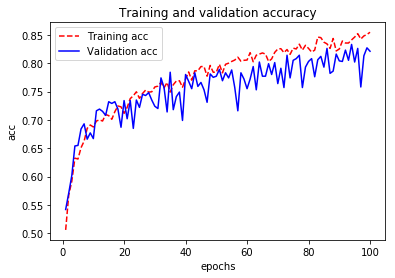

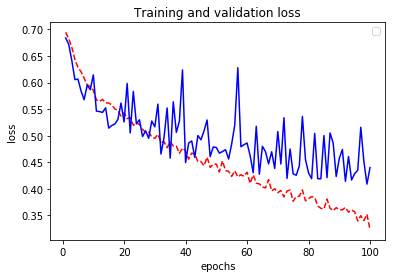

<Figure size 432x288 with 0 Axes>

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt


acc      = historyDA.history[     'acc' ]
val_acc  = historyDA.history[ 'val_acc' ]
loss     = historyDA.history[    'loss' ]
val_loss = historyDA.history['val_loss' ]

epochs    = range(1,len(acc)+1,1) # obtener número de epochs

plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot  ( epochs,     loss, 'r--' )
plt.plot  ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()



### ModelFE: Modelo con *Feature Extraction*

In [0]:
import tensorflow as tf

from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


pre_trained_model.summary()

for layer in pre_trained_model.layers:
  layer.trainable = False


pre_trained_model.summary()




58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [0]:
modelFE = tf.keras.models.Sequential([
    pre_trained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [0]:
modelFE.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

test_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))





Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
from tensorflow.keras.optimizers import RMSprop

modelFE.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

batch_size = 20
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

historyFE = modelFE.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = steps_per_epoch,
            epochs = 100,
            validation_steps = validation_steps,
            verbose = 2)



Epoch 1/100
100/100 - 28s - loss: 0.5403 - acc: 0.7215 - val_loss: 0.3155 - val_acc: 0.8770
Epoch 2/100
100/100 - 25s - loss: 0.4322 - acc: 0.8015 - val_loss: 0.2698 - val_acc: 0.8940
Epoch 3/100
100/100 - 25s - loss: 0.3738 - acc: 0.8350 - val_loss: 0.2601 - val_acc: 0.8900
Epoch 4/100
100/100 - 25s - loss: 0.3596 - acc: 0.8415 - val_loss: 0.2557 - val_acc: 0.8910
Epoch 5/100
100/100 - 25s - loss: 0.3423 - acc: 0.8435 - val_loss: 0.2517 - val_acc: 0.8990
Epoch 6/100
100/100 - 25s - loss: 0.3359 - acc: 0.8555 - val_loss: 0.2396 - val_acc: 0.9070
Epoch 7/100
100/100 - 25s - loss: 0.3333 - acc: 0.8545 - val_loss: 0.2650 - val_acc: 0.8930
Epoch 8/100
100/100 - 25s - loss: 0.3344 - acc: 0.8475 - val_loss: 0.2468 - val_acc: 0.9020
Epoch 9/100
100/100 - 25s - loss: 0.3141 - acc: 0.8615 - val_loss: 0.2988 - val_acc: 0.8740
Epoch 10/100
100/100 - 25s - loss: 0.3184 - acc: 0.8585 - val_loss: 0.2455 - val_acc: 0.9020
Epoch 11/100
100/100 - 25s - loss: 0.3215 - acc: 0.8575 - val_loss: 0.2487 - va

In [0]:
test_lost, test_acc= modelFE.evaluate_generator(test_generator)
print ("Test Accuracy:", test_acc)

Test Accuracy: 0.9


W0903 10:47:21.038351 140067097810816 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

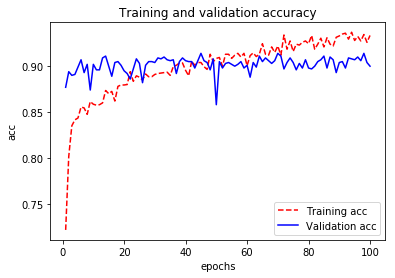

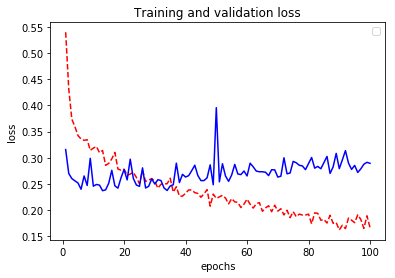

<Figure size 432x288 with 0 Axes>

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt


acc      = historyFE.history[     'acc' ]
val_acc  = historyFE.history[ 'val_acc' ]
loss     = historyFE.history[    'loss' ]
val_loss = historyFE.history['val_loss' ]

epochs    = range(1,len(acc)+1,1) # obtener número de epochs

plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
#plt.ylim(0,1)
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot  ( epochs,     loss, 'r--' )
plt.plot  ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')
#plt.ylim(0,1)

plt.legend()
plt.figure()




### ModelFT : Modelo con *Fine Tuning*

In [0]:
import tensorflow as tf

from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')

pre_trained_model.trainable = True

set_trainable = False


for layer in pre_trained_model.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable: 
    layer.trainable = True
  else:
    layer.trainable = False

pre_trained_model.summary()




Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
modelFT = tf.keras.models.Sequential([
    pre_trained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

modelFT.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
from tensorflow.keras.optimizers import RMSprop

modelFT.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4), 
              metrics=['acc'])

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


test_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
batch_size = 20
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

historyFT = modelFT.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = steps_per_epoch,
            epochs = 100,
            validation_steps = validation_steps,
            verbose = 2)


Epoch 1/100
100/100 - 29s - loss: 0.5147 - acc: 0.7550 - val_loss: 0.3326 - val_acc: 0.8700
Epoch 2/100
100/100 - 26s - loss: 0.3605 - acc: 0.8450 - val_loss: 0.2648 - val_acc: 0.8800
Epoch 3/100
100/100 - 26s - loss: 0.2781 - acc: 0.8805 - val_loss: 0.1782 - val_acc: 0.9230
Epoch 4/100
100/100 - 26s - loss: 0.2684 - acc: 0.8955 - val_loss: 0.1695 - val_acc: 0.9220
Epoch 5/100
100/100 - 26s - loss: 0.2433 - acc: 0.8975 - val_loss: 0.1893 - val_acc: 0.9180
Epoch 6/100
100/100 - 26s - loss: 0.2358 - acc: 0.9035 - val_loss: 0.1749 - val_acc: 0.9280
Epoch 7/100
100/100 - 26s - loss: 0.2572 - acc: 0.9085 - val_loss: 0.1784 - val_acc: 0.9310
Epoch 8/100
100/100 - 26s - loss: 0.2101 - acc: 0.9195 - val_loss: 0.1819 - val_acc: 0.9290
Epoch 9/100
100/100 - 26s - loss: 0.1979 - acc: 0.9250 - val_loss: 0.1911 - val_acc: 0.9260
Epoch 10/100
100/100 - 26s - loss: 0.1958 - acc: 0.9285 - val_loss: 0.2873 - val_acc: 0.8960
Epoch 11/100
100/100 - 26s - loss: 0.2073 - acc: 0.9225 - val_loss: 0.2322 - va

W0903 11:31:10.621910 140067097810816 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

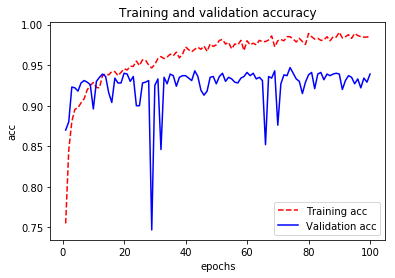

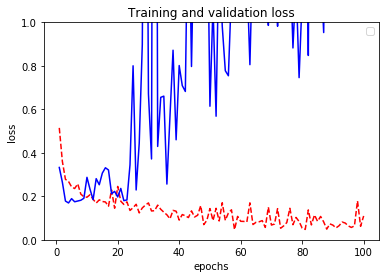

<Figure size 432x288 with 0 Axes>

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc      = historyFT.history[     'acc' ]
val_acc  = historyFT.history[ 'val_acc' ]
loss     = historyFT.history[    'loss' ]
val_loss = historyFT.history['val_loss' ]

epochs    = range(1,len(acc)+1,1) # obtener número de epochs

plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
#plt.ylim(0,1)
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot  ( epochs,     loss, 'r--' )
plt.plot  ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')
plt.ylim(0,1)

plt.legend()
plt.figure()



In [0]:
test_lost, test_acc= modelFT.evaluate_generator(test_generator)
print ("Test Accuracy:", test_acc)

Test Accuracy: 0.939


<Figure size 432x288 with 0 Axes>

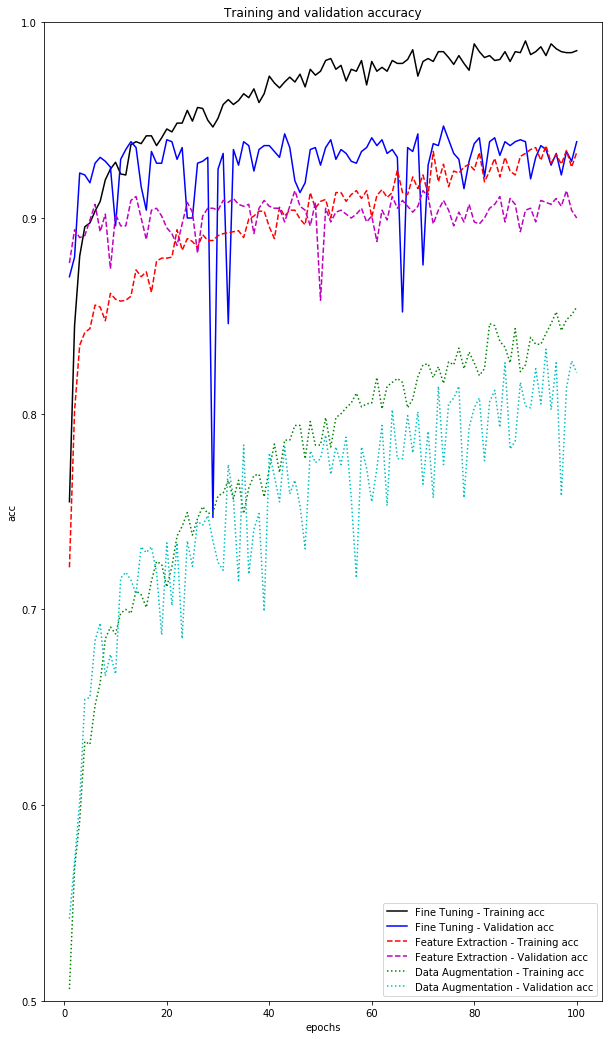

<Figure size 432x288 with 0 Axes>

In [0]:

accDA      = historyDA.history[     'acc' ]
val_accDA  = historyDA.history[ 'val_acc' ]

accFE      = historyFE.history[     'acc' ]
val_accFE  = historyFE.history[ 'val_acc' ]

accFT      = historyFT.history[     'acc' ]
val_accFT  = historyFT.history[ 'val_acc' ]

epochs    = range(1,len(accDA)+1,1) 

plt.figure(figsize=(10,18))

plt.plot  ( epochs,     accFT, 'k', label='Fine Tuning - Training acc '  )
plt.plot  ( epochs, val_accFT,  'b', label='Fine Tuning - Validation acc ')

plt.plot  ( epochs,     accFE, 'r--', label='Feature Extraction - Training acc'  )
plt.plot  ( epochs, val_accFE,  'm--', label='Feature Extraction - Validation acc')

plt.plot  ( epochs,     accDA, 'g:', label='Data Augmentation - Training acc'  )
plt.plot  ( epochs, val_accDA,  'c:', label='Data Augmentation - Validation acc')

plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.ylim(0.5,1)
plt.xlabel('epochs')


plt.legend()
plt.figure()





Using TensorFlow backend.


Saving Wiliams-foto1.jpg to Wiliams-foto1 (1).jpg
[0.]


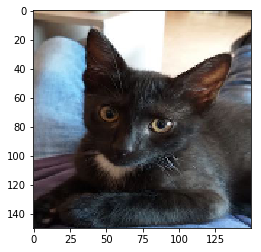

Wiliams-foto1.jpg IS A CAT


In [0]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = modelFT.predict(images, batch_size=10)
  
  print(classes[0])
  
  plt.imshow(img)  
  plt.show()
  
  if classes[0]>0:
    print( fn + " IS A DOG")
    
  else:
    print( fn + " IS A CAT")





Antes de pasar al siguiente capítulo, ejecutar el siguiente código para terminar el proceso y liberar los recursos.

In [0]:
import os, signal

os.kill( os.getpid() , 
         signal.SIGKILL
       )
